# CPSC 477 Final Project

Team: Eugene Han, Ali Aldous, Elder Veliz

In [1]:
# standard library imports
import gc
import os
import random
import sys
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# third party imports
import numpy as np
import pandas as pd
import torch
from adapters import AutoAdapterModel
from joblib import dump, load
from pytorch_lightning import Trainer, LightningModule
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, 
    ConfusionMatrixDisplay, 
    f1_score
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.svm import LinearSVC
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import (
    AdamW, 
    AutoTokenizer, 
    RobertaForSequenceClassification, 
    get_linear_schedule_with_warmup
)

# local imports
sys.path.append("../")
from src import ArXivScraper

## Scrape Statistics Papers from ArXiv

In [2]:
# Since all the data has already been scraped, running this won't do anything
# To scrape from scratch, delete `raw_data.csv` inside the `data` folder
# WARNING: Scraping from scratch will take a long time. The arXiv's API is also extremely brittle.
scraper = ArXivScraper()
scraper()

## Setup
### Device and Reproducibility

In [2]:
# Select device
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

# Set seeds for reproducibility
SEED = 0

random.seed(SEED)
np.random.seed(SEED)

if torch.cuda.is_available():
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.deterministic = True
elif torch.backends.mps.is_available():
    torch.mps.manual_seed(SEED)

### Data

In [3]:
# Data handling
WORKING_DIR = os.path.dirname("__file__")
DATA_DIR = os.path.join(WORKING_DIR, "..", "data")
MODELS_DIR = os.path.join(WORKING_DIR, "..", "models")
CATEGORY_TO_ID = {
    "stat.AP": 0,
    "stat.CO": 1,
    "stat.ME": 2,
    "stat.ML": 3,
    "stat.TH": 4
}
ID_TO_CATEGORY = {
    v: k for k, v in CATEGORY_TO_ID.items()
}
N_CLASSES = len(CATEGORY_TO_ID)

train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))

# Inspect first few rows of data
train_df.head()

,Title,Abstract,Primary Category
0,A Parallel algorithm for $\mathcal{X}$-Armed b...,The target of $\mathcal{X}$-armed bandit probl...,stat.ML
1,Explaining the behavior of joint and marginal ...,In latent variable models the parameter estima...,stat.CO
2,Multiscale Partial Information Decomposition o...,Heart rate variability results from the combin...,stat.ME
3,A Sequentially Fair Mechanism for Multiple Sen...,In the standard use case of Algorithmic Fairne...,stat.ML
4,Higher Order Generalization Error for First Or...,We propose a novel approach to analyze general...,stat.ML


In [4]:
# Create custom Dataset to be used for PyTorch models
class ArXivDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=256):
        self.titles = data["Title"]
        self.abstracts = data["Abstract"]
        self.labels = data["Primary Category"].map(CATEGORY_TO_ID)
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.titles)
    
    def encode_text(self, idx):
        text = self.titles.iloc[idx] + self.tokenizer.sep_token + self.abstracts.iloc[idx]

        return self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

    def __getitem__(self, idx):
        encoding = self.encode_text(idx)
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)
        label = torch.tensor(self.labels.iloc[idx], dtype=torch.long)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": label
        }

### Custom Scikit-learn Column Transformer

In [9]:
# Define function to be used as custom column transformer in sklearn pipeline
# Performs simple concatenation of the title and abstract
def combine_text(X):
    X = X.copy()
    X["Text"] = X["Title"] + X["Abstract"]
    X = X.drop(columns=["Title", "Abstract"])

    return X["Text"]


class SpecterFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, tokenizer, model):
        self.tokenizer = tokenizer
        self.model = model
        self.model.to(DEVICE)
        self.model.eval()

    def _encode_text(self, text):
        inputs = self.tokenizer(
            text,
            padding=True,
            truncation=True,
            return_tensors="pt",
            return_token_type_ids=False,
            max_length=512
        )

        return inputs

    def _create_embedding(self, text):
        inputs = self._encode_text(text)
        inputs = inputs.to(DEVICE)
        output = self.model(**inputs)
        embedding = output.last_hidden_state[:, 0, :].squeeze(0).cpu().numpy()

        return embedding

    def transform(self, X):
        texts = X["Title"] + self.tokenizer.sep_token + X["Abstract"]
        texts = texts.tolist()

        with torch.no_grad():
            embeddings = np.stack([self._create_embedding(text) for text in texts])

        return embeddings

    def fit(self, X, y=None):
        return self

### PyTorch Lightning Modules

In [6]:
# Define lightning modules
# Baseline RoBERTa
class RobertaBaseline(LightningModule):
    def __init__(self, epochs=10):
        super().__init__()
        self.model = RobertaForSequenceClassification.from_pretrained(
            "roberta-base", 
            num_labels=N_CLASSES
        )

        # Freeze pretrained part
        for param in self.model.roberta.parameters():
            param.requires_grad = False
        
        self.epochs = epochs

    def forward(self, input_ids, attention_mask, labels=None):
        return self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]
        outputs = self(input_ids, attention_mask, labels)
        loss = outputs.loss
        self.log(
            "train_loss", 
            loss, 
            on_step=True, 
            on_epoch=True, 
            prog_bar=True, 
            logger=True, 
            sync_dist=True
        )

        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=1e-3)
        total_steps = len(train_loader) * self.epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer, 
            num_warmup_steps=0, 
            num_training_steps=total_steps
        )
        scheduler_config = {'scheduler': scheduler, 'interval': 'step', 'frequency': 1}

        return [optimizer], [scheduler_config]

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]
        outputs = self(input_ids, attention_mask, labels)
        loss = outputs.loss
        self.log(
            "test_loss", 
            loss, 
            on_step=True, 
            on_epoch=True, 
            prog_bar=True, 
            logger=True, 
            sync_dist=True
        )

        return loss


# Fine-tuning RoBERTa
class RobertaFineTuned(LightningModule):
    def __init__(self, epochs=10):
        super().__init__()
        self.model = RobertaForSequenceClassification.from_pretrained(
            "roberta-base", 
            num_labels=N_CLASSES
        )
        self.epochs = epochs

    def forward(self, input_ids, attention_mask, labels=None):
        return self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]
        outputs = self(input_ids, attention_mask, labels)
        loss = outputs.loss
        self.log(
            "train_loss", 
            loss, 
            on_step=True, 
            on_epoch=True, 
            prog_bar=True, 
            logger=True, 
            sync_dist=True
        )

        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=4e-5)
        total_steps = len(train_loader) * self.epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer, 
            num_warmup_steps=0, 
            num_training_steps=total_steps
        )
        scheduler_config = {'scheduler': scheduler, 'interval': 'step', 'frequency': 1}

        return [optimizer], [scheduler_config]

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]
        outputs = self(input_ids, attention_mask, labels)
        loss = outputs.loss
        self.log(
            "test_loss", 
            loss, 
            on_step=True, 
            on_epoch=True, 
            prog_bar=True, 
            logger=True, 
            sync_dist=True
        )

        return loss

## Model Training

To train from scratch, run the following cells. Training was done using Yale's HPC clusters. To save time and/or see the final results, skip these cells and go to the Evaluation section.

In [7]:
available_gpus = [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]
available_gpus

['Quadro RTX 5000']

### Baselines

#### TF-IDF + Linear SVC

In [8]:
# Create inputs and labels
X_train, y_train = train_df.drop(columns=["Primary Category"]), train_df["Primary Category"]

# Define pipeline object
pipe = Pipeline([
    ("combine_text", FunctionTransformer(combine_text)),
    ("tfidf", TfidfVectorizer()),
    ("clf", LinearSVC(dual=True, random_state=42, max_iter=5000))
])

# Define hyperparameter grid
param_grid = {
    "tfidf__stop_words": ["english", None],
    "clf__C": [0.1, 0.25, 0.5],
}

# Perform grid search using stratified 5-fold CV scheme, optimizing for macro-averaged F1
grid = GridSearchCV(pipe, param_grid, cv=5, scoring="f1_macro", n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)

{'clf__C': 0.25, 'tfidf__stop_words': None}


In [9]:
# Save the model to disk
dump(grid, os.path.join(MODELS_DIR, "tfidf_svc.joblib"))

['../models/tfidf_svc.joblib']

#### SPECTER2 Embeddings + Logistic Regression

In [10]:
# Set tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter2_base')

# Set embedding model
model = AutoAdapterModel.from_pretrained('allenai/specter2_base')
model.load_adapter("allenai/specter2_classification", source="hf", load_as="classification", set_active=True)

# Define the pipeline
X_train, y_train = train_df.drop(columns=["Primary Category"]), train_df["Primary Category"]

# Keep the feature extraction separate from main pipeline because it can't be pickled
feat_extractor = SpecterFeatureExtractor(tokenizer, model)
X_train_feat = feat_extractor.fit_transform(X_train)

pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(random_state=0, max_iter=1000)),
    ]
)

pipe.fit(X_train_feat, y_train)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(max_iter=1000, random_state=0))])

In [11]:
# Save the model to disk
dump(pipe, os.path.join(MODELS_DIR, "specter2_logreg.joblib"))

['../models/specter2_logreg.joblib']

#### RoBERTa Baseline

Only the classification head parameters are trained, the rest are frozen.

In [13]:
# Set tokenizer
tokenizer_roberta = AutoTokenizer.from_pretrained("roberta-base")

# Create datasets and data loaders
train_dataset = ArXivDataset(train_df, tokenizer_roberta)
test_dataset = ArXivDataset(test_df, tokenizer_roberta)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Training
num_epochs = 10
model = RobertaBaseline(epochs=num_epochs)

trainer = Trainer(
    max_epochs=num_epochs,
    accelerator="cuda",
    enable_progress_bar=True
)

trainer.fit(model, train_loader)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | RobertaForSequenceClassification | 124 M 
-----------------------------------------------------------
594 K     Trainable params
124 M     Non-trainable params
124 M     Total params
498.598   Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [14]:
# Save model checkpoint
trainer.save_checkpoint(os.path.join(MODELS_DIR, "roberta_baseline.ckpt"))

### Our Approach

#### Fine-Tuning RoBERTa

In [15]:
# Set tokenizer
tokenizer_roberta = AutoTokenizer.from_pretrained("roberta-base")

# Create datasets and data loaders
train_dataset = ArXivDataset(train_df, tokenizer_roberta)
test_dataset = ArXivDataset(test_df, tokenizer_roberta)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Training
num_epochs = 10
model = RobertaFineTuned(epochs=num_epochs)

trainer = Trainer(
    max_epochs=num_epochs,
    accelerator="cuda",
    enable_progress_bar=True
)

trainer.fit(model, train_loader)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | RobertaForSequenceClassification | 124 M 
-----------------------------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
498.598   Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [16]:
# Save model checkpoint
trainer.save_checkpoint(os.path.join(MODELS_DIR, "roberta_finetuned.ckpt"))

## Evaluation
### Baselines
#### TF-IDF + Linear SVC

----Test Results for TF-IDF + Linear SVC----
              precision    recall  f1-score   support

     stat.AP     0.6778    0.5765    0.6230      2576
     stat.CO     0.6011    0.4280    0.5000      1007
     stat.ME     0.6434    0.6903    0.6660      5540
     stat.ML     0.7791    0.8033    0.7910      4824
     stat.TH     0.7128    0.7333    0.7229      4248

    accuracy                         0.6996     18195
   macro avg     0.6828    0.6463    0.6606     18195
weighted avg     0.6981    0.6996    0.6972     18195

Macro-Averaged F1-Score: 0.6605889385710653


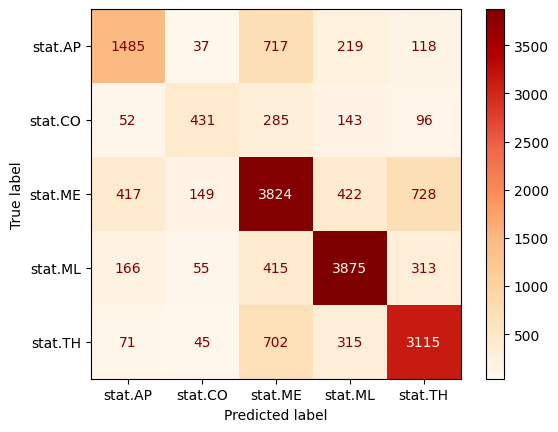

In [10]:
# Load model and get predictions
model = load(os.path.join(MODELS_DIR, "tfidf_svc.joblib"))
X_test, y_test = test_df.drop(columns=["Primary Category"]), test_df["Primary Category"]
y_pred = model.predict(X_test)

# Results
print("----Test Results for TF-IDF + Linear SVC----")
print(classification_report(y_test, y_pred, digits=4))
print(f"Macro-Averaged F1-Score: {f1_score(y_test, y_pred, average='macro')}")

disp1 = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="OrRd")

#### SPECTER2 Embeddings + Logistic Regression

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

----Test Results for SPECTER2 + Logistic Regression----
              precision    recall  f1-score   support

     stat.AP     0.6782    0.6161    0.6456      2576
     stat.CO     0.5726    0.4657    0.5137      1007
     stat.ME     0.6449    0.6819    0.6629      5540
     stat.ML     0.7775    0.7975    0.7874      4824
     stat.TH     0.7206    0.7175    0.7190      4248

    accuracy                         0.6996     18195
   macro avg     0.6788    0.6557    0.6657     18195
weighted avg     0.6984    0.6996    0.6983     18195

Macro-Averaged F1-Score: 0.6657300882224848


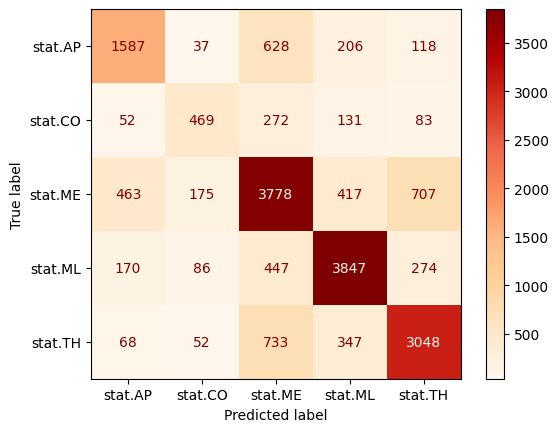

In [11]:
# Load model and get predictions
model = load(os.path.join(MODELS_DIR, "specter2_logreg.joblib"))
X_test, y_test = test_df.drop(columns=["Primary Category"]), test_df["Primary Category"]

tokenizer = AutoTokenizer.from_pretrained('allenai/specter2_base')
embedding_model = AutoAdapterModel.from_pretrained('allenai/specter2_base')
embedding_model.load_adapter("allenai/specter2_classification", source="hf", load_as="classification", set_active=True)
feat_extractor = SpecterFeatureExtractor(tokenizer, embedding_model)

X_test_feat = feat_extractor.transform(X_test)
y_pred = model.predict(X_test_feat)

# Results
print("----Test Results for SPECTER2 + Logistic Regression----")
print(classification_report(y_test, y_pred, digits=4))
print(f"Macro-Averaged F1-Score: {f1_score(y_test, y_pred, average='macro')}")

disp1 = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="OrRd")

#### RoBERTa Baseline

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1138/1138 [03:18<00:00,  5.73batch/s]


----Test Results for Baseline RoBERTa----
              precision    recall  f1-score   support

     stat.AP     0.6623    0.5741    0.6151      2576
     stat.CO     0.5112    0.3625    0.4242      1007
     stat.ME     0.5994    0.6590    0.6278      5540
     stat.ML     0.7484    0.7448    0.7466      4824
     stat.TH     0.6864    0.7039    0.6950      4248

    accuracy                         0.6638     18195
   macro avg     0.6415    0.6089    0.6217     18195
weighted avg     0.6632    0.6638    0.6619     18195

Macro-Averaged F1-Score: 0.6217393325391107


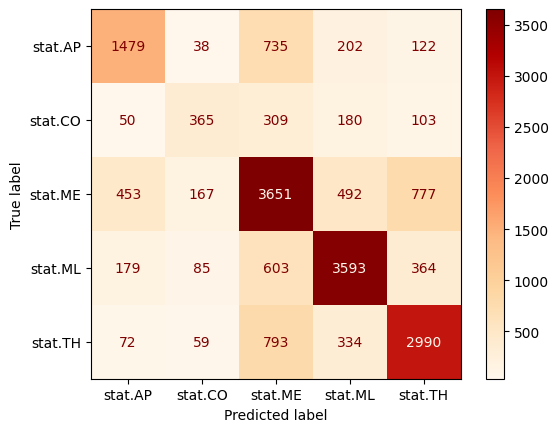

In [12]:
# Load model and get predictions
model = RobertaBaseline.load_from_checkpoint(os.path.join(MODELS_DIR, "roberta_baseline.ckpt"))
model.to(DEVICE)
model.eval()

tokenizer_roberta = AutoTokenizer.from_pretrained("roberta-base")
test_dataset = ArXivDataset(test_df, tokenizer_roberta)
test_loader = DataLoader(test_dataset, batch_size=16)

y_test = []
y_pred = []
for batch in tqdm(test_loader, unit="batch"):
    input_ids = batch["input_ids"].to("cuda")
    attention_mask = batch["attention_mask"].to("cuda")

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
    true_labels = batch["label"].cpu().numpy()

    y_test.extend(true_labels)
    y_pred.extend(predicted_labels)

y_test = np.vectorize(ID_TO_CATEGORY.get)(y_test)
y_pred = np.vectorize(ID_TO_CATEGORY.get)(y_pred)

# Results
print("----Test Results for Baseline RoBERTa----")
print(classification_report(y_test, y_pred, digits=4))
print(f"Macro-Averaged F1-Score: {f1_score(y_test, y_pred, average='macro')}")

disp1 = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="OrRd")

### Our Approach

#### Fine-Tuning RoBERTa

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1138/1138 [03:24<00:00,  5.56batch/s]


----Test Results for Fine-Tuned RoBERTa----
              precision    recall  f1-score   support

     stat.AP     0.6576    0.6114    0.6337      2576
     stat.CO     0.5280    0.4687    0.4966      1007
     stat.ME     0.6215    0.6884    0.6532      5540
     stat.ML     0.7878    0.7896    0.7887      4824
     stat.TH     0.7336    0.6794    0.7055      4248

    accuracy                         0.6901     18195
   macro avg     0.6657    0.6475    0.6555     18195
weighted avg     0.6917    0.6901    0.6899     18195

Macro-Averaged F1-Score: 0.6555303028423487


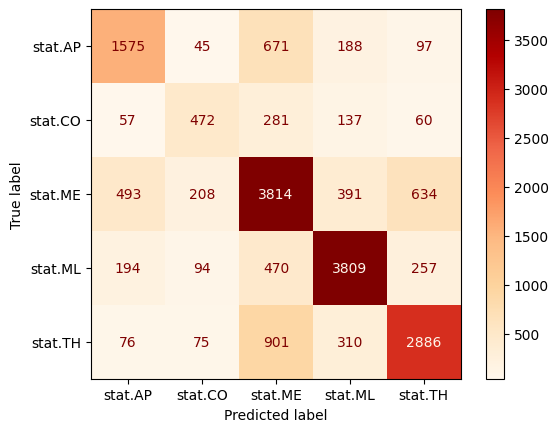

In [13]:
# Load model and get predictions
model = RobertaFineTuned.load_from_checkpoint(os.path.join(MODELS_DIR, "roberta_finetuned.ckpt"))
model.to(DEVICE)
model.eval()

tokenizer_roberta = AutoTokenizer.from_pretrained("roberta-base")
test_dataset = ArXivDataset(test_df, tokenizer_roberta)
test_loader = DataLoader(test_dataset, batch_size=16)

y_test = []
y_pred = []
for batch in tqdm(test_loader, unit="batch"):
    input_ids = batch["input_ids"].to("cuda")
    attention_mask = batch["attention_mask"].to("cuda")

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
    true_labels = batch["label"].cpu().numpy()

    y_test.extend(true_labels)
    y_pred.extend(predicted_labels)

y_test = np.vectorize(ID_TO_CATEGORY.get)(y_test)
y_pred = np.vectorize(ID_TO_CATEGORY.get)(y_pred)

# Results
print("----Test Results for Fine-Tuned RoBERTa----")
print(classification_report(y_test, y_pred, digits=4))
print(f"Macro-Averaged F1-Score: {f1_score(y_test, y_pred, average='macro')}")

disp1 = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="OrRd")